In [1]:
!pip install catboost
!pip install ngboost
!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq

  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.4
    Uninstalling scipy-1.5.4:
      Successfully uninstalled scipy-1.5.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 2.3.10 requires scipy<=1.5.4, but you have scipy 1.7.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
formulaic 0.3.4 requires scipy>=1.6, but you have scipy 1.5.4 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# 라이브러리 Import
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings


from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.utils import shuffle
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from ngboost import NGBRegressor
from pycaret.regression import *


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
data_train = pd.read_csv('/content/gdrive/MyDrive/데이콘_소비자데이터기반_소비예측/train.csv')
data_test = pd.read_csv('/content/gdrive/MyDrive/데이콘_소비자데이터기반_소비예측/test.csv')
submission = pd.read_csv('/content/gdrive/MyDrive/데이콘_소비자데이터기반_소비예측/sample_submission.csv')

In [5]:
print(data_train.shape)
data_train.head(3).transpose()

(1108, 22)


,0,1,2
id,0,1,2
Year_Birth,1974,1962,1951
Education,Master,Graduation,Graduation
Marital_Status,Together,Single,Married
Income,46014.0,76624.0,75903.0
Kidhome,1,0,0
Teenhome,1,1,1
Dt_Customer,21-01-2013,24-05-2014,08-04-2013
Recency,21,68,50
NumDealsPurchases,10,1,2


In [6]:
print(data_test.shape)
data_test.head(3).transpose()

(1108, 21)


,0,1,2
id,0,1,2
Year_Birth,1979,1955,1984
Education,Graduation,Graduation,Graduation
Marital_Status,Single,Together,Married
Income,57537.0,65748.0,55434.0
Kidhome,1,0,1
Teenhome,0,1,0
Dt_Customer,10-06-2013,15-04-2013,05-10-2013
Recency,83,58,21
NumDealsPurchases,4,2,3


In [7]:
submission.head(3)

,id,target
0,0,0
1,1,0
2,2,0


### Feature 설명
- id : 샘플 아이디
- Year_Birth : 고객 생년원일
- Education : 고객 학력
- Marital_status : 고객 결혼 상태
- Income : 고객 연간 가구 소득
- Kidhome : 고객 가구의 자녀 수
- Teenhome : 고객 가구의 청소년 수
- Dt_Customer : 고객이 회사에 등록한 날짜
- Recency : 고객의 마지막 구매 이후 일수
- NumDealsPurchases : 할인된 구매 횟수
- NumWebPurchases : 회사 웹사이트를 통한 구매 건수
- NumCatalogPurchases: 카탈로그를 사용한 구매 수
- NumStorePuchases : 매장에서 직접 구매한 횟수
- NumWebVisitsMonth : 지난 달 회사 웹사이트 방문 횟수
- AcceptedCmp1: 고객이 첫 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp2: 고객이 두 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp3: 고객이 세 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp4: 고객이 네 번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- AcceptedCmp5: 고객이 5번째 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- Complain : 고객이 지난 2년 동안 불만을 제기한 경우 1, 그렇지 않은 경우 0
- Response : 고객이 마지막 캠페인에서 제안을 수락한 경우 1, 그렇지 않은 경우 0
- target : 고객의 제품 총 소비량

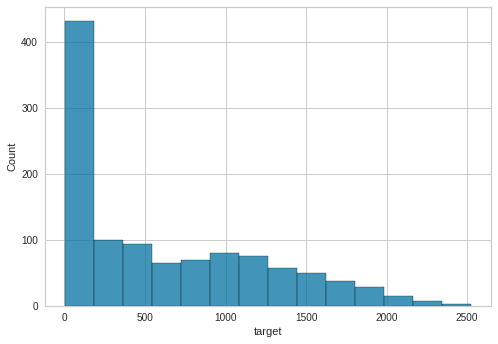

In [8]:
sns.histplot(data_train['target'])

In [9]:
# Range라는 새로운 feature 만들기 
data_train_T = data_train['target']
target = []
for i in range(len(data_train_T)):
  if data_train_T.iloc[i]<250:
    target.append(1)
  elif data_train_T.iloc[i] < 1000:
    target.append(2)
  elif data_train_T.iloc[i] < 1800:
    target.append(3)
  else:
    target.append(4)

data_train["Range"] = target

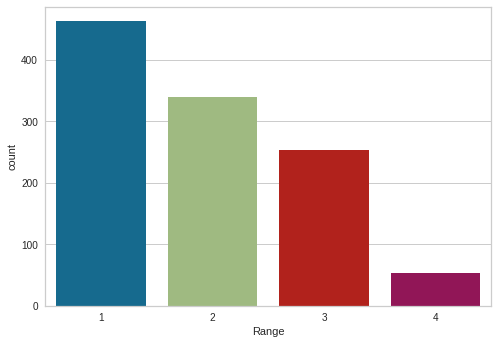

In [10]:
sns.countplot(x = data_train['Range'])

target의 분포가 0~250 사이의 데이터가 많고, 2000 이후의 샘플에 대한 데이터가 충분하지 않아 ,high target에 대해서 잘 맞추지 못한다.

# 데이터 전처리
- 데이터 전처리
- 새로운 feature 생성

In [11]:
# object 형태의 데이터를 학습 가능한 형태로 변경시켜줘야 한다.
# Education, Marital_Status, Dt_Customer
data_train.dtypes

id                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
target                   int64
Range                    int64
dtype: object

### 문자 자료형 Education, Marital_Status 숫자로 인코딩 하기

In [12]:
data_train['Education']

0           Master
1       Graduation
2       Graduation
3            Basic
4              PhD
           ...    
1103    Graduation
1104    Graduation
1105        Master
1106    Graduation
1107           PhD
Name: Education, Length: 1108, dtype: object

In [13]:
data_train['Education'].value_counts()

Graduation    570
PhD           254
Master        173
2n Cycle       89
Basic          22
Name: Education, dtype: int64

## Education - label encoding 사용
- Basic, Graduation, 2n_cycle, Master, phD
- 0, 1, 2, 3, 4

In [14]:
# train set 및 test set에 적용
for data in [data_train, data_test]:
  for i in range(len(data_train)):
    education = data['Education'].iloc[i]
    if education in ["Basic"]:
      data['Education'].iloc[i]=0
    elif education in ['Graduation']:
      data['Education'].iloc[i] =1
    elif education in ['2n_cycle']:
      data['Education'].iloc[i] = 2
    elif education in ['Master']:
      data['Education'].iloc[i] = 3
    else:
      data['Education'].iloc[i]=4

## one hot encoding 사용하여 결혼 / 싱글 두가지로 인코딩
- 결혼, 동거 = 0, Married, Together
- 싱글 = Single, Divorced, Widow, Alone, YOLO, Absurd

In [15]:
# train set 및 test set에 적용
for data in [data_train, data_test]:
  for i in range(data.shape[0]):
    marital_status = data['Marital_Status'].iloc[i]
    if marital_status in ['Married', 'Together']:
      data['Marital_Status'].iloc[i] = 0
    else:
      data['Marital_Status'].iloc[i] = 1

### 타임스탬프 Dt_Customer를 회사 가입 개월수인 Sign_Month로 변환
- sign_month = 사이트에 가입하고 몇개월이나 지났는가? 높을수록 예전에 가입한사람

In [16]:
for data in [data_train, data_test]:
    for i in range(data.shape[0]):
        data['Dt_Customer'].iloc[i] = int(data['Dt_Customer'].iloc[i][-1]) * 12 + int(data['Dt_Customer'].iloc[i][3:5])
        
recent_month = max(data_train['Dt_Customer'])

for data in [data_train, data_test]:
    month_arr = []
    for i in range(data.shape[0]):
        month_arr.append(recent_month - data['Dt_Customer'].iloc[i])
        
    data['Sign_Month'] = month_arr

## 새로운 Feature 만들기

### AcceptedCmp(1~5)와 Response 변수로 새 Feature 생성
- 위 여섯개의 변수는 고객이 1~5번째와 마지막 캠페인에서 제안을 수락한 경우 1, 아닌 경우 0값을 가진다.
- 모두 더해서 하나의 변수로 만들어주기

In [17]:
data_train['total_Accept'] = data_train['AcceptedCmp1'] + data_train['AcceptedCmp2'] +data_train['AcceptedCmp3'] +data_train['AcceptedCmp4'] + data_train['AcceptedCmp5'] +data_train['Response'] 
data_test['total_Accept'] = data_test['AcceptedCmp1'] + data_test['AcceptedCmp2'] +data_test['AcceptedCmp3'] +data_test['AcceptedCmp4'] + data_test['AcceptedCmp5'] +data_test['Response'] 

### Year_Birth를 이용해 나이 Age Feature 만들기

In [18]:
data_train['Age'] = 2022 - data_train['Year_Birth']
data_test['Age'] = 2022 - data_test['Year_Birth']

### Dependents = Kidhome + Teenhome
- Kidhome : 고객 가구의 자녀 수
- Teenhome : 고객 가구의 청소년 수
- 중첩되는 부분이 있을 수 있지만 모델의 성능에는 도움을 줄 수 있을 것 같다.

In [19]:
data_train['Dependents'] = data_train['Kidhome'] + data_train['Teenhome']
data_test['Dependents'] = data_test['Kidhome'] + data_test['Teenhome']

## 필요 없는 Feature 삭제

In [20]:
data_train = data_train.drop(['id','Dt_Customer', 'Year_Birth','Education','Marital_Status'], axis=1)
data_test = data_test.drop(['id','Dt_Customer', 'Year_Birth','Education','Marital_Status'], axis=1)

# 모델 생성 및 학습하기
- stratified k-fold 사용
- LGBM, XGB, Catboost
- Voting 사용

In [21]:
data_train_X = data_train.drop(["target"], axis = 1)
data_train_y = data_train["target"]

In [22]:
def NMAE(true, pred):
    score = np.mean(np.abs(true - pred) / true)
    return score

In [23]:
# overfitting을 방지하기 위해 skf 진행
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True) #총 10번의 fold 진행
n = 0 #x번째 fold인지 기록

fold_target_pred = []
fold_score = []


# 앞에서 만든 range 기준으로 stratified k fold 진행
for train_index, valid_index in skf.split(data_train_X, data_train_X['Range']): 
    n += 1
    
    val_pred_name = [] #validation pred model 이름 저장
    val_pred = []      #validation set pred 결과 저장
    target_pred = []   #test set pred 결과 저장
    
    #분배된 학습을 위해 생성한 Range feature 제거
    train_X = np.array(data_train_X.drop("Range", axis = 1)) 
    train_Y = np.array(data_train_y)
    
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_Y[train_index], train_Y[valid_index]
    
    X_test = np.array(data_test)

    ### Create Model ###
    
    ###모델을 생성하고 집어넣으면 됩니다.
    
    ### LGBMRegressor ###
    model = LGBMRegressor(random_state = 42, verbose = 0) 
    model.fit(X_train, y_train) # 모델 학습
    
    val_pred_name.append("LGBMRegressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### XGBRegressor ###
    model = XGBRegressor(random_state = 42) 
    model.fit(X_train, y_train)
    
    val_pred_name.append("XGBRegressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### CatBoostRegressor ###
    model = CatBoostRegressor(random_state = 42) 
    model.fit(X_train, y_train)
    
    val_pred_name.append("CatBoostRegressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### voting ###
    
    ### average validation pred ###
    preds = np.array(val_pred[0])
    for i in range(1, len(val_pred)):
        preds += val_pred[i] # validation predict 값을 다 합친 것
    
    preds = preds/len(val_pred) # validation predict 평균
    
    ### average target pred ###
    target_preds = np.array(target_pred[0])
    for i in range(1, len(target_pred)):
        target_preds += target_pred[i] # data_test predict를 모두 더한 값.
    
    target_preds = target_preds/len(target_pred) # data_test predict 평균
    
    fold_target_pred.append(target_preds) # append final target pred
    
    print("========== fold %d ==========" %(n))
    for i in range(len(val_pred)):
        print("%s model NMAE : %0.4f" %(val_pred_name[i], NMAE(y_valid, val_pred[i].astype(int))))
        
    print("==============================")
    print("Average NMAE %0.4f" %(NMAE(y_valid, preds.astype(int))))
    print("")
    
    fold_score.append(NMAE(y_valid, preds.astype(int)))

total_score = fold_score[0]
for i in range(2, len(fold_score), 1):
    total_score += fold_score[i]
total_score = total_score/(len(fold_score))    

print("==============================")
print("Total Average NMAE %0.4f" %(total_score)) #최종 average score 출력

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
57:	learn: 216.3569995	total: 149ms	remaining: 2.41s
58:	learn: 214.5938378	total: 151ms	remaining: 2.4s
59:	learn: 213.2162125	total: 152ms	remaining: 2.38s
60:	learn: 211.8415378	total: 153ms	remaining: 2.35s
61:	learn: 210.4140560	total: 154ms	remaining: 2.33s
62:	learn: 208.7845299	total: 155ms	remaining: 2.3s
63:	learn: 207.8501696	total: 156ms	remaining: 2.28s
64:	learn: 206.6619353	total: 157ms	remaining: 2.26s
65:	learn: 205.6664313	total: 159ms	remaining: 2.25s
66:	learn: 204.2550129	total: 168ms	remaining: 2.34s
67:	learn: 203.2364121	total: 171ms	remaining: 2.34s
68:	learn: 202.5048342	total: 173ms	remaining: 2.34s
69:	learn: 200.9528046	total: 176ms	remaining: 2.33s
70:	learn: 199.7289338	total: 177ms	remaining: 2.31s
71:	learn: 198.4305063	total: 178ms	remaining: 2.29s
72:	learn: 197.0295393	total: 179ms	remaining: 2.27s
73:	learn: 196.2323947	total: 181ms	remaining: 2.26s
74:	learn: 195.2268945	total: 183ms	remaining: 2.26s
75:	learn: 1

In [24]:
### average target pred ###
final_pred = np.array(fold_target_pred[0])
for i in range(1, len(fold_target_pred)):
    final_pred += fold_target_pred[i]

final_pred = final_pred/len(fold_target_pred)
final_pred = final_pred.astype(int)

In [25]:
submission['target'] = final_pred
submission.head()

,id,target
0,0,527
1,1,779
2,2,768
3,3,1238
4,4,1277


In [26]:
submission.to_csv("submission.csv",index=False)

# Pycaret 사용
- pycaret을 통해 어떤 모델이 괜찮은지 확인
- 모델 3개를 선정해 앞의 과정을 다시 진행
- pycaret과 stratified k-fold를 동시에 진행하는 방법은 아직 찾지 못함

In [27]:
# 모델 선언
reg = setup(data_train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            # train_size = 0.8,  # 학습에 전체 사용시 빈칸으로 
            target = 'target', # 목표 변수
            use_gpu = False, # GPU가 있으면 사용 (Cat BOost 속도 향상)
            session_id = 2021,
            fold_shuffle = True
            )



,Description,Value
0,session_id,2021
1,Target,target
2,Original Data,"(1108, 22)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,17
6,Transformed Train Set,"(775, 21)"
7,Transformed Test Set,"(333, 21)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [28]:
top10 = compare_models(n_select=10, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,65.5478,12318.7661,109.9670,0.9650,0.2175,0.1706,0.505
catboost,CatBoost Regressor,68.8174,13778.1585,115.9409,0.9614,0.2821,0.2320,1.422
rf,Random Forest Regressor,70.8225,13423.8241,115.1917,0.9617,0.2302,0.1868,0.602
gbr,Gradient Boosting Regressor,77.6150,14815.1037,120.9273,0.9580,0.2956,0.2539,0.116
dt,Decision Tree Regressor,85.6307,22865.2370,150.2862,0.9340,0.2989,0.2268,0.019
ada,AdaBoost Regressor,99.3915,19027.4306,137.3241,0.9454,0.4724,0.4963,0.103
lasso,Lasso Regression,115.0743,25158.8409,157.7216,0.9276,0.7617,0.5563,0.017
br,Bayesian Ridge,115.6285,25295.4969,158.1744,0.9271,0.7462,0.5666,0.015
ridge,Ridge Regression,115.8003,25299.9768,158.1940,0.9271,0.7467,0.5662,0.014
llar,Lasso Least Angle Regression,116.0775,26886.5675,162.7571,0.9226,0.4761,0.4691,0.015


In [29]:
from sklearn import ensemble

In [30]:
# overfitting을 방지하기 위해 skf 진행
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True) #총 10번의 fold 진행
n = 0 #x번째 fold인지 기록

fold_target_pred = []
fold_score = []


# 앞에서 만든 range 기준으로 stratified k fold 진행
for train_index, valid_index in skf.split(data_train_X, data_train_X['Range']): 
    n += 1
    
    val_pred_name = [] #validation pred model 이름 저장
    val_pred = []      #validation set pred 결과 저장
    target_pred = []   #test set pred 결과 저장
    
    #분배된 학습을 위해 생성한 Range feature 제거
    train_X = np.array(data_train_X.drop("Range", axis = 1)) 
    train_Y = np.array(data_train_y)
    
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_Y[train_index], train_Y[valid_index]
    
    X_test = np.array(data_test)

    ### Create Model ###
    
    ###모델을 생성하고 집어넣으면 됩니다.
    
    ### Extra Trees Regressor ###
    model = ensemble.ExtraTreesRegressor(random_state = 42) 
    model.fit(X_train, y_train) # 모델 학습
    
    val_pred_name.append("Extra Trees Regressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### Random Forest Regresso ###
    model = ensemble.RandomForestRegressor(random_state = 42) 
    model.fit(X_train, y_train)
    
    val_pred_name.append("Random Forest Regressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### CatBoostRegressor ###
    model = CatBoostRegressor(random_state = 42) 
    model.fit(X_train, y_train)
    
    val_pred_name.append("CatBoostRegressor")      # 모델 이름 저장
    val_pred.append(model.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model.predict(X_test)) # test set pred 결과 저장
    
    ### voting ###
    
    ### average validation pred ###
    preds = np.array(val_pred[0])
    for i in range(1, len(val_pred)):
        preds += val_pred[i] # validation predict 값을 다 합친 것
    
    preds = preds/len(val_pred) # validation predict 평균
    
    ### average target pred ###
    target_preds = np.array(target_pred[0])
    for i in range(1, len(target_pred)):
        target_preds += target_pred[i] # data_test predict를 모두 더한 값.
    
    target_preds = target_preds/len(target_pred) # data_test predict 평균
    
    fold_target_pred.append(target_preds) # append final target pred
    
    print("========== fold %d ==========" %(n))
    for i in range(len(val_pred)):
        print("%s model NMAE : %0.4f" %(val_pred_name[i], NMAE(y_valid, val_pred[i].astype(int))))
        
    print("==============================")
    print("Average NMAE %0.4f" %(NMAE(y_valid, preds.astype(int))))
    print("")
    
    fold_score.append(NMAE(y_valid, preds.astype(int)))

total_score = fold_score[0]
for i in range(2, len(fold_score), 1):
    total_score += fold_score[i]
total_score = total_score/(len(fold_score))    

print("==============================")
print("Total Average NMAE %0.4f" %(total_score)) #최종 average score 출력

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
41:	learn: 251.0215838	total: 69.9ms	remaining: 1.59s
42:	learn: 247.9660818	total: 71.3ms	remaining: 1.59s
43:	learn: 244.7430373	total: 72.9ms	remaining: 1.58s
44:	learn: 242.0499108	total: 74.3ms	remaining: 1.58s
45:	learn: 239.8092584	total: 75.6ms	remaining: 1.57s
46:	learn: 237.2389918	total: 77ms	remaining: 1.56s
47:	learn: 235.0846422	total: 78.3ms	remaining: 1.55s
48:	learn: 232.8532953	total: 79.6ms	remaining: 1.54s
49:	learn: 230.8403455	total: 80.8ms	remaining: 1.53s
50:	learn: 228.4345433	total: 82.2ms	remaining: 1.53s
51:	learn: 226.6925709	total: 83.5ms	remaining: 1.52s
52:	learn: 224.6587109	total: 84.8ms	remaining: 1.52s
53:	learn: 222.8140028	total: 86.4ms	remaining: 1.51s
54:	learn: 221.3493792	total: 87.7ms	remaining: 1.51s
55:	learn: 219.6802055	total: 89ms	remaining: 1.5s
56:	learn: 217.9251718	total: 90.3ms	remaining: 1.49s
57:	learn: 216.3569995	total: 91.7ms	remaining: 1.49s
58:	learn: 214.5938378	total: 93ms	remaining: 1.48s

## Pycaret을 통해 뽑은 모델 3개로 stratified k fold를 진행했을 때, 더 좋은 성능이 나왔다.